# RTA workload

The RTA or RTApp workload represents a type of workload obtained using the rt-app test application.
More details on the test application can be found at https://github.com/scheduler-tools/rt-app.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2016-12-08 12:02:29,102 INFO    : root         : Using LISA logging configuration:
2016-12-08 12:02:29,103 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
# Generate plots inline
%pylab inline

import json
import os

# Support to initialise and configure your test environment
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp, Step, Pulse

# Suport for FTrace events parsing and visualization
import trappy

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

Populating the interactive namespace from numpy and matplotlib


## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',  # juno - JUNO board with mainline hwmon
    
    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.1',
    "username"    : 'root',
    "password"    : 'juno',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "cpu_frequency"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using
# - the provided target configuration (my_target_conf)
# - the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2016-12-07 10:25:45,152 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-07 10:25:45,153 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-07 10:25:45,153 INFO    : TestEnv      : Loading custom (inline) test configuration
2016-12-07 10:25:45,153 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'hwmon']
2016-12-07 10:25:45,154 INFO    : TestEnv      : Connecting linux target:
2016-12-07 10:25:45,154 INFO    : TestEnv      :   username : root
2016-12-07 10:25:45,155 INFO    : TestEnv      :       host : 192.168.0.1
2016-12-07 10:25:45,155 INFO    : TestEnv      :   password : juno
2016-12-07 10:25:45,156 INFO    : TestEnv      : Connection settings:
2016-12-07 10:25:45,156 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2016-12-07 10:26:02,855 INFO    : TestEnv      : Initializing target workdir:
2016-12-07 10:26:02,856 INFO    : TestEnv      :    /root/devlib-target
2016-12-07 

## Workload configuration

To create an instance of an RTApp workload generator you need to provide the following:
- target: target device configuration
- name: name of workload. This is the name of the JSON configuration file reporting the generated RTApp configuration.
- calibration: CPU load calibration values, measured on each core.

An RTApp workload is defined by specifying a **kind**, provided below through **rtapp.conf**, which represents the way we want to define the behavior of each task.
The possible kinds of workloads are **profile** and **custom**. It's very important to notice that **periodic** is no longer considered a "kind" of workload but a "class" within the **profile** kind.
<br><br>
As you see below, when "kind" is "profile", the tasks generated by this workload have a profile which is defined by a sequence of phases. These phases are defined according to the following grammar:<br>
 - params := {task, ...} <br>
 - task   := NAME : {SCLASS, PRIO, [phase, ...]}<br>
 - phase  := (PTIME, PERIOD, DCYCLE)<br> <br>
 
There are some pre-defined task classes for the **profile** kind:
 - **Step**: the load of this task is a step with a configured initial and final load. 
 - **Pulse**: the load of this task is a pulse with a configured initial and final load.The main difference with the 'step' class is that a pulse workload is by definition a 'step down', i.e. the workload switches from an initial load to a final one which is always lower than the initial one. Moreover, a pulse load does not generate a sleep phase in case of 0[%] load, i.e. the task ends as soon as the non null initial load has completed.
 - **Ramp**: the load of this task is a ramp with a configured number of steps determined by the input parameters.
 - **Periodic**: the load of this task is periodic with a configured period and duty-cycle.<br><br>
The one below is a workload mix having all types of workloads described above, but each of them can also be specified serapately in the RTApp parameters. 

In [5]:
# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
# 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={

        # 3. PERIODIC task
        # 
        # This class defines a task which load is periodic with a configured
        # period and duty-cycle.
        # 
        # This class is a specialization of the 'pulse' class since a periodic
        # load is generated as a sequence of pulse loads.
        # 
        # Args:
        #     cuty_cycle_pct  (int, [0-100]): the pulses load [%]
        #                                     default: 50[%]
        #     duration_s  (float): the duration in [s] of the entire workload
        #                          default: 1.0[s]
        #     period_ms   (float): the period used to define the load in [ms]
        #                          default: 100.0[ms]
        #     delay_s     (float): the delay in [s] before ramp start
        #                          default: 0[s]
        #     sched       (dict):  the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_per20': Periodic(
            period_ms=100,         # period
            duty_cycle_pct=20,     # duty cycle
            duration_s=5,          # duration
            cpus=None,             # run on all CPUS
            sched={
                "policy": "FIFO",  # Run this task as a SCHED_FIFO task
            },
            delay_s=0              # start at the start of RTApp
        ).get(),

        # 4. RAMP task
        #
        # This class defines a task which load is a ramp with a configured number
        # of steps according to the input parameters.
        # 
        # Args:
        #     start_pct (int, [0-100]): the initial load [%], (default 0[%])
        #     end_pct   (int, [0-100]): the final load [%], (default 100[%])
        #     delta_pct (int, [0-100]): the load increase/decrease [%],
        #                               default: 10[%]
        #                               increase if start_prc < end_prc
        #                               decrease  if start_prc > end_prc
        #     time_s    (float): the duration in [s] of each load step
        #                        default: 1.0[s]
        #     period_ms (float): the period used to define the load in [ms]
        #                        default: 100.0[ms]
        #     delay_s   (float): the delay in [s] before ramp start
        #                        default: 0[s]
        #     loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        #     sched     (dict): the scheduler configuration for this task
        #     cpus      (list): the list of CPUs on which task can run
        'task_rmp20_5-60': Ramp(
            period_ms=100,         # period
            start_pct=5,           # intial load
            end_pct=65,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1[s]
            cpus="0"               # run just on first CPU
        ).get(),
        
        # 5. STEP task
        # 
        # This class defines a task which load is a step with a configured
        # initial and final load.
        # 
        # Args:
        # start_pct (int, [0-100]): the initial load [%]
        #                               default 0[%])
        # end_pct   (int, [0-100]): the final load [%]
        #                               default 100[%]
        # time_s    (float): the duration in [s] of the start and end load
        #                        default: 1.0[s]
        # period_ms (float): the period used to define the load in [ms]
        #                        default 100.0[ms]
        # delay_s   (float): the delay in [s] before ramp start
        #                        default 0[s]
        # loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        # sched     (dict): the scheduler configuration for this task
        # cpus      (list): the list of CPUs on which task can run
        'task_stp10-50': Step(
            period_ms=100,         # period
            start_pct=0,           # intial load
            end_pct=50,            # end load
            time_s=1,              # ... every 1[s]
            delay_s=0.5            # start .5[s] after the start of RTApp
        ).get(),
        
        # 6. PULSE task
        #
        # This class defines a task which load is a pulse with a configured
        # initial and final load.
        # 
        # The main difference with the 'step' class is that a pulse workload is
        # by definition a 'step down', i.e. the workload switch from an finial
        # load to a final one which is always lower than the initial one.
        # Moreover, a pulse load does not generate a sleep phase in case of 0[%]
        # load, i.e. the task ends as soon as the non null initial load has
        # completed.
        # 
        # Args:
        #     start_pct (int, [0-100]): the initial load [%]
        #                               default: 0[%]
        #     end_pct   (int, [0-100]): the final load [%]
        #                               default: 100[%]
        #               NOTE: must be lower than start_pct value
        #     time_s    (float): the duration in [s] of the start and end load
        #                        default: 1.0[s]
        #                        NOTE: if end_pct is 0, the task end after the
        #                        start_pct period completed
        #     period_ms (float): the period used to define the load in [ms]
        #                        default: 100.0[ms]
        #     delay_s   (float): the delay in [s] before ramp start
        #                        default: 0[s]
        #     loops     (int):   number of time to repeat the ramp, with the
        #                        specified delay in between
        #                        default: 0
        #     sched     (dict):  the scheduler configuration for this task
        #     cpus      (list):  the list of CPUs on which task can run
        'task_pls5-80': Pulse(
            period_ms=100,         # period
            start_pct=65,          # intial load
            end_pct=5,             # end load
            time_s=1,              # ... every 1[s]
            delay_s=0.5            # start .5[s] after the start of RTApp
        ).get(),
        
        
    },
    
    # 7. use this folder for task logfiles
    run_dir=target.working_directory
    
);

2016-12-07 10:27:16,946 INFO    : Workload     : Setup new workload simple
2016-12-07 10:27:16,947 INFO    : Workload     : Workload duration defined by longest task
2016-12-07 10:27:16,947 INFO    : Workload     : Default policy: SCHED_OTHER
2016-12-07 10:27:16,948 INFO    : Workload     : ------------------------
2016-12-07 10:27:16,948 INFO    : Workload     : task [task_per20], sched: {'policy': 'FIFO'}
2016-12-07 10:27:16,949 INFO    : Workload     :  | calibration CPU: 1
2016-12-07 10:27:16,949 INFO    : Workload     :  | loops count: 1
2016-12-07 10:27:16,949 INFO    : Workload     : + phase_000001: duration 5.000000 [s] (50 loops)
2016-12-07 10:27:16,950 INFO    : Workload     : |  period   100000 [us], duty_cycle  20 %
2016-12-07 10:27:16,950 INFO    : Workload     : |  run_time  20000 [us], sleep_time  80000 [us]
2016-12-07 10:27:16,951 INFO    : Workload     : ------------------------
2016-12-07 10:27:16,951 INFO    : Workload     : task [task_pls5-80], sched: using default 

The output of the previous cell reports the main properties of the generated
tasks. Thus for example we see that the first task is configure to be:
 - named **task_per20**
 - executed as a **SCHED_FIFO** task
 - generating a load which is **calibrated** with respect to the **CPU 1**
 - with one single "phase" which defines a peripodic load for the **duration** of **5[s]**
 - that periodic load consistes of **50 cycles**
 - each cycle has a **period** of **100[ms]** and a **duty-cycle** of **20%**,
   which means that the task, for every cycle, will **run** for **20[ms]** and then sleep for **80[ms]** 

All these properties are translated into a JSON configuration file for RTApp which you can see in **Collected results** below.<br>

## Workload composition

Another way of specifying the phases of a task is through workload composition, described in the next cell.<br>
**NOTE:** We are just giving this as an example of specifying a workload, but this configuration won't be the one used for the following execution and analysis cells. You need to uncomment these lines if you want to use the composed workload.

In [6]:
# Initial phase and pinning parameters
ramp = Ramp(period_ms=100, start_pct=5, end_pct=65, delta_pct=20, time_s=1, cpus="0")

# Following phases
medium_slow = Periodic(duty_cycle_pct=10, duration_s=5, period_ms=100, cpus="0")
high_fast   = Periodic(duty_cycle_pct=60, duration_s=5, period_ms=10, cpus="0")
medium_fast = Periodic(duty_cycle_pct=10, duration_s=5, period_ms=1, cpus="0")
high_slow   = Periodic(duty_cycle_pct=60, duration_s=5, period_ms=100, cpus="0")

#Compose the task
complex_task = ramp + medium_slow + high_fast + medium_fast + high_slow

# Configure this RTApp instance to:
# rtapp.conf(
#    # 1. generate a "profile based" set of tasks
#    kind='profile',
#    
#    # 2. define the "profile" of each task
#    params={
#        'complex' : complex_task.get()
#    },
#
#    # 6. use this folder for task logfiles
#    run_dir='/tmp'
#)

## Workload execution

In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
nrg_report = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

2016-12-07 10:27:30,511 INFO    : root         : #### Setup FTrace
2016-12-07 10:27:38,104 INFO    : root         : #### Start energy sampling
2016-12-07 10:27:38,723 INFO    : root         : #### Start RTApp execution
2016-12-07 10:27:38,726 INFO    : Workload     : Workload execution START:
2016-12-07 10:27:38,728 INFO    : Workload     :    /root/devlib-target/bin/rt-app /root/devlib-target/simple_00.json 2>&1
2016-12-07 10:27:54,778 INFO    : root         : #### Read energy consumption: /home/vagrant/lisa/results/20161207_102628/energy.json
2016-12-07 10:27:55,401 INFO    : root         : #### Stop FTrace
2016-12-07 10:27:57,663 INFO    : root         : #### Save FTrace: /home/vagrant/lisa/results/20161207_102628/trace.dat
2016-12-07 10:28:03,718 INFO    : root         : #### Save platform description: /home/vagrant/lisa/results/20161207_102628/platform.json


## Collected results

In [8]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
print json.dumps(rtapp_json, indent=4, sort_keys=True)

2016-12-07 10:29:04,768 INFO    : root         : Generated RTApp JSON file:


{
    "global": {
        "calibration": 138, 
        "default_policy": "SCHED_OTHER", 
        "duration": -1, 
        "logdir": "/root/devlib-target"
    }, 
    "tasks": {
        "task_per20": {
            "loop": 1, 
            "phases": {
                "p000001": {
                    "loop": 50, 
                    "run": 20000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_per20"
                    }
                }
            }, 
            "policy": "SCHED_FIFO"
        }, 
        "task_pls5-80": {
            "loop": 1, 
            "phases": {
                "p000000": {
                    "delay": 500000
                }, 
                "p000001": {
                    "loop": 10, 
                    "run": 65000, 
                    "timer": {
                        "period": 100000, 
                        "ref": "task_pls5-80"
                    }
                }, 
               

In [9]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

2016-12-07 10:29:06,513 INFO    : root         : Content of the output folder /home/vagrant/lisa/results/20161207_102628


total 3592
drwxrwxr-x  2 user user    4096 Dec  7 10:28 .
drwxrwxr-x 22 user user    4096 Dec  7 10:26 ..
-rw-rw-r--  1 user user      68 Dec  7 10:27 energy.json
-rw-rw-r--  1 user user     705 Dec  7 10:27 output.log
-rw-rw-r--  1 user user     673 Dec  7 10:28 platform.json
-rw-r--r--  1 user user    6360 Dec  7 10:27 rt-app-task_per20-0.log
-rw-r--r--  1 user user    2764 Dec  7 10:27 rt-app-task_pls5-80-1.log
-rw-r--r--  1 user user    5120 Dec  7 10:27 rt-app-task_rmp20_5-60-2.log
-rw-r--r--  1 user user    1648 Dec  7 10:27 rt-app-task_stp10-50-3.log
-rw-r--r--  1 user user    3104 Dec  7 10:27 simple_00.json
-rw-r--r--  1 user user 3629056 Dec  7 10:28 trace.dat


In [10]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_report.report_file)
print json.dumps(nrg_report.channels, indent=4, sort_keys=True)

2016-12-07 10:29:09,792 INFO    : root         : Energy: /home/vagrant/lisa/results/20161207_102628/energy.json


{
    "LITTLE": 1.8224460000000136, 
    "big": 0.5827259999999796
}


In [11]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
print json.dumps(plt, indent=4, sort_keys=True)

2016-12-07 10:29:14,705 INFO    : root         : Platform description: /home/vagrant/lisa/results/20161207_102628/platform.json


{
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            450000, 
            625000, 
            800000, 
            950000, 
            1100000
        ], 
        "little": [
            450000, 
            575000, 
            700000, 
            775000, 
            850000
        ]
    }, 
    "nrg_model": null, 
    "topology": [
        [
            0, 
            3, 
            4, 
            5
        ], 
        [
            1, 
            2
        ]
    ]
}


## Trace inspection

More information on visualization and trace inspection can be found in **examples/trappy**.

In [12]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

## RTApp task performance plots

2016-12-07 10:29:27,425 INFO    : PerfAnalysis : PerfIndex, Task [task_rmp20_5-60] avg: -5.34, std: 8.79
2016-12-07 10:29:27,795 INFO    : PerfAnalysis : PerfIndex, Task [task_pls5-80] avg: -8.28, std: 7.04
2016-12-07 10:29:28,161 INFO    : PerfAnalysis : PerfIndex, Task [task_stp10-50] avg: -24.23, std: 1.75
2016-12-07 10:29:28,546 INFO    : PerfAnalysis : PerfIndex, Task [task_per20] avg: 0.56, std: 0.06


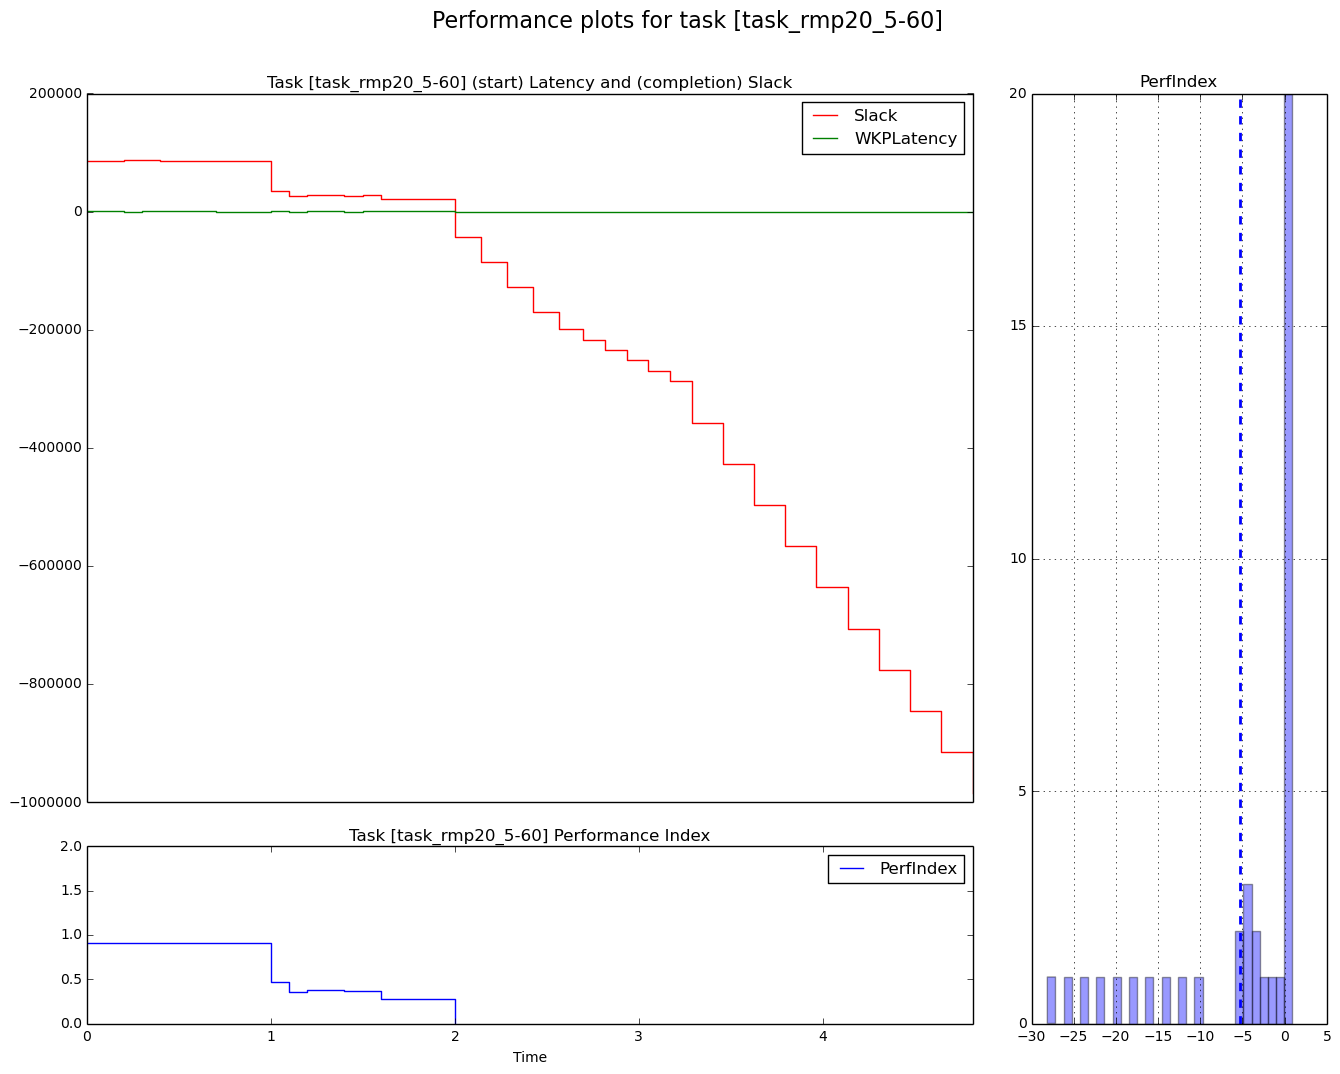

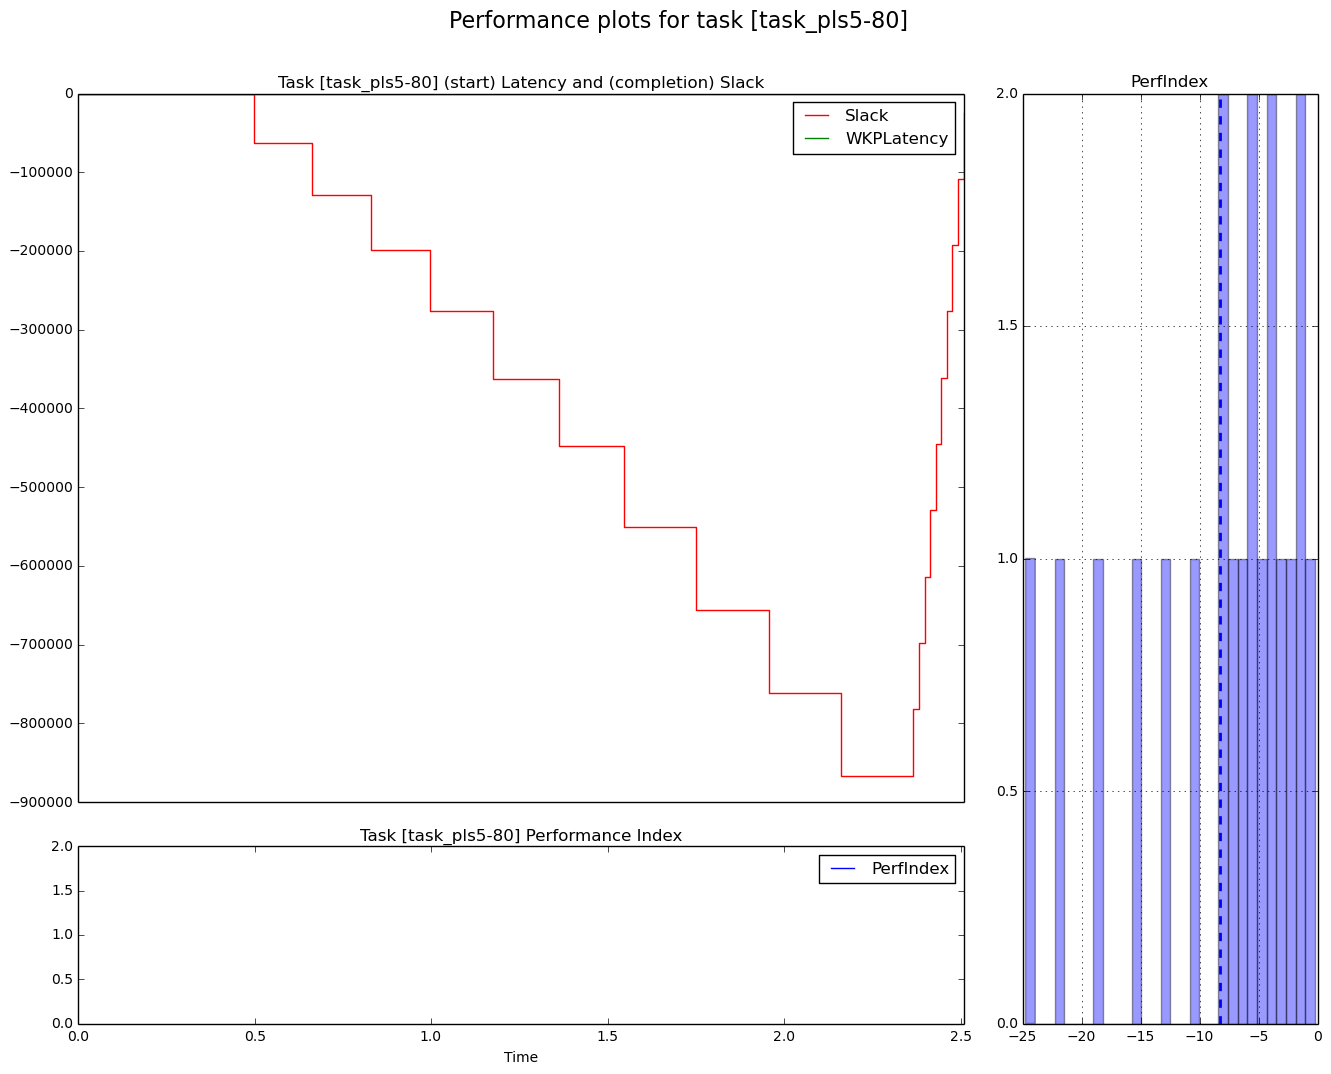

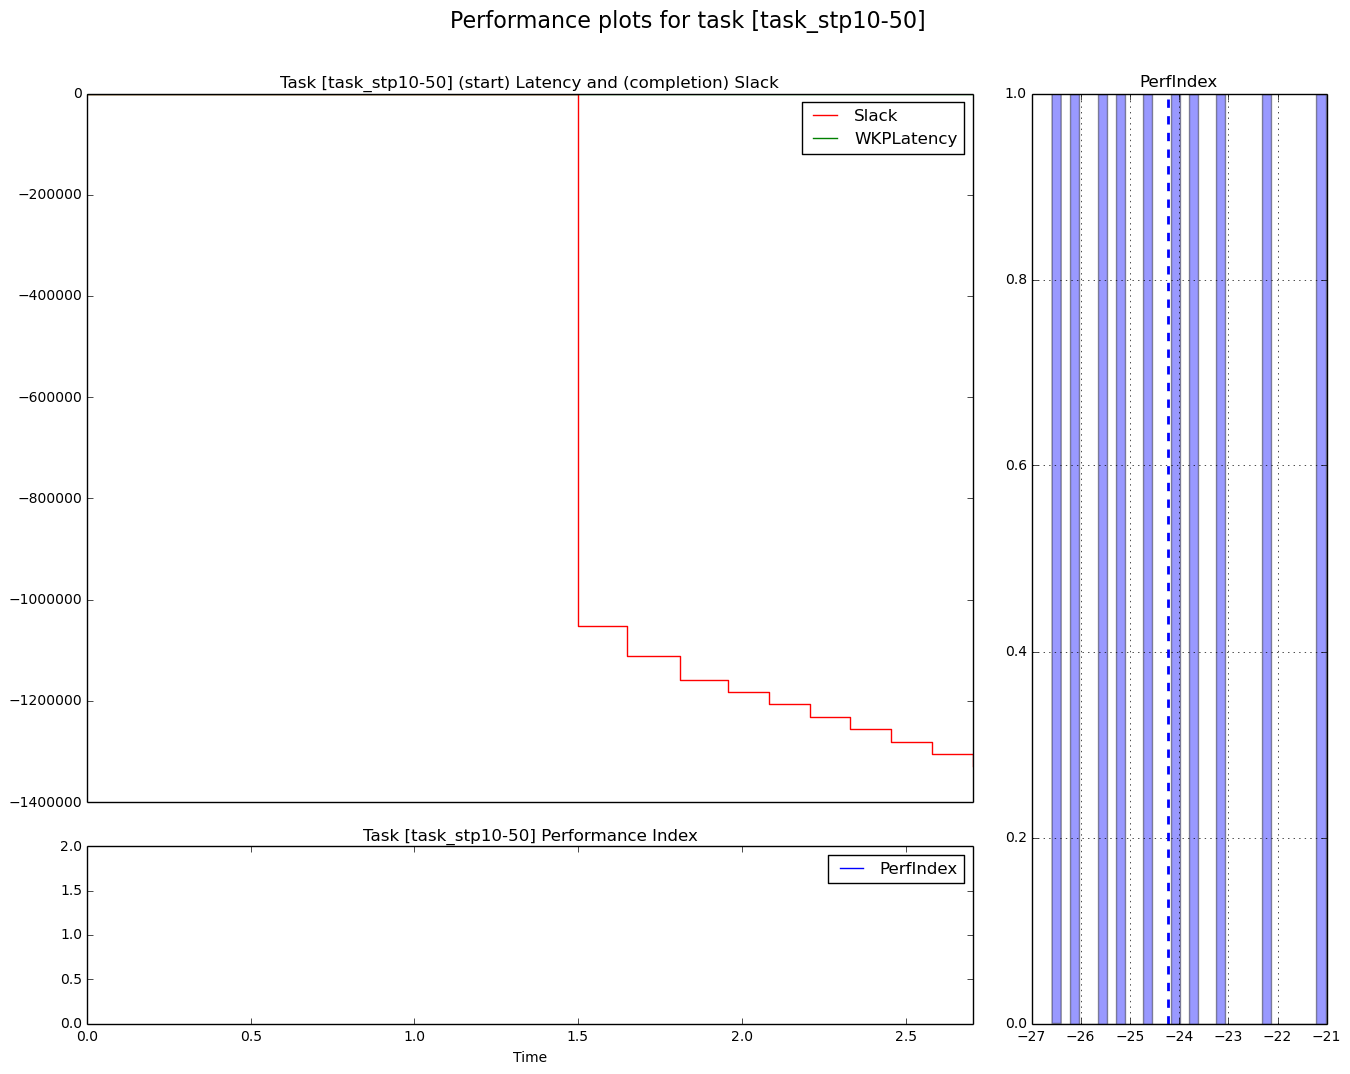

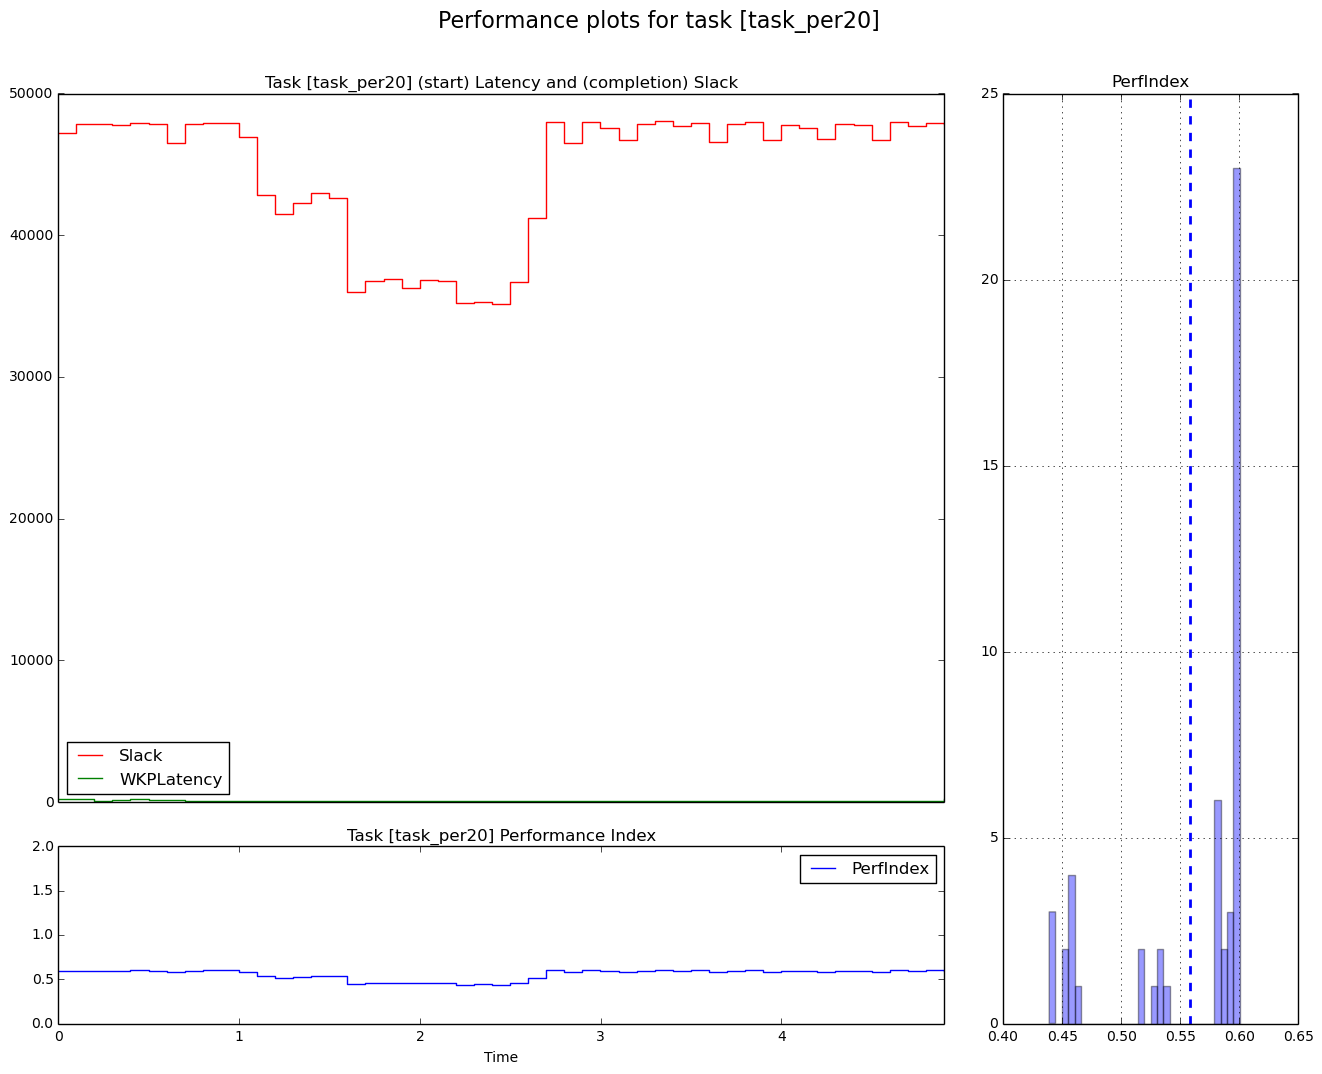

In [13]:
# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))